# Введение в нейронные сети
## Задание 1

### Импортируем все необходимые библиотеки

In [1]:
"""
Разпознование цифр Mnist с помощью PyTorch.

Смотрел примеры:

https://github.com/pytorch/examples/tree/main/mnist_hogwild

https://medium.com/@ramamurthi96/a-simple-neural-network-model-for-mnist-using-pytorch-4b8b148ecbdc

https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/

https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch/notebook

"""

from typing import Tuple

import numpy as np
from matplotlib import pyplot as plt

import torch

from torchvision import datasets, transforms

from torch.utils.data import DataLoader
from torch import optim
from torch import nn
import torch.nn.functional as torch_func

from prettytable import PrettyTable

### Скачиваем датасет mnist

In [3]:

def one_hot_transform(target):
    return torch_func.one_hot(torch.tensor(target), num_classes=10).to(dtype=torch.float)

def get_train_and_test_data(batch_size=10, batch_size_test=4):
    # x (входы) трансформируем в тензоры
    transform = transforms.ToTensor()
    """
    так же можно применять несколько трасформаторов и данные нормализовать и/или конвертировать в диапазон [0, 1]
    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0.1307,), (0.3081,))
    ])
    """

    # y (ответы) кодируем в one_hot, т.к категории

    target_transform = one_hot_transform

    print(f"mnist start load ...")

    mnist_train = datasets.MNIST(root='mnist', download=True, train=True, transform=transform,
                                 target_transform=target_transform)
    mnist_test = datasets.MNIST(root='mnist', download=True, train=False, transform=transform,
                                target_transform=target_transform)

    train_loader = DataLoader(mnist_train, batch_size=batch_size)
    test_loader = DataLoader(mnist_test, batch_size=batch_size_test)

    print(f"mnist loaded ...")

    return train_loader, test_loader

**Создаём модель 1**

In [4]:
def create_model(norm=False):
    """
    Создание модели
    :param norm:
    Создать слой для нормализации данных
    :return: Модель
    """
    model = nn.Sequential()
    model.append(nn.Flatten())

    if norm:
        model.append(nn.LayerNorm(784))

    model.append(nn.Linear(in_features=784, out_features=128))
    model.append(nn.ReLU())
    model.append(nn.Linear(in_features=128, out_features=64))
    model.append(nn.ReLU())
    model.append(nn.Linear(in_features=64, out_features=10))
    model.append(nn.Sigmoid())

    return model

**Создаём модель 2**

In [5]:
def create_model_conv2d():
    """
    Создание более сложной/тяжелой модели
    :return:
    """
    model = new_model = nn.Sequential()

    model.append(nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=0))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=0))
    model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2, 2)))
    model.append(nn.Dropout(0.25))

    model.append(nn.Flatten())
    model.append(nn.Linear(32 * 12 * 12, 128))
    model.append(nn.ReLU())
    model.append(nn.Dropout(0.5))
    model.append(nn.Linear(in_features=128, out_features=10))
    model.append(nn.Softmax(dim=1))

    return new_model

**Фукции для обучение модели**

In [6]:
def train(model, train_loader, loss_function, optimizer, device, epoch, log_interval=-1) -> Tuple[float, float]:
    """
    Обучение модели и сбор метрик: loss и accuracy
    :param model:
    :param train_loader:
    :param loss_function:
    :param optimizer:
    :param device:
    :param epoch:
    :param log_interval:
    :return:
    """
    model.train()

    total_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)

        prediction = output.argmax(axis=1, keepdims=True)
        y_n = target.argmax(axis=1, keepdims=True)
        correct += prediction.eq(y_n.view_as(prediction)).sum().item()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if log_interval > 0 & (batch_idx % log_interval == 0):
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    total_items = len(train_loader.dataset)

    total_loss /= total_items
    correct /= total_items

    return total_loss, correct


def eval_model(model, train_loader, loss_function, device, epoch, log_interval=-1) -> Tuple[float, float]:
    """
    Проверка модели на тестовой выборке и сбор метрик: loss и accuracy
    :param model:
    :param train_loader:
    :param loss_function:
    :param device:
    :param epoch:
    :param log_interval:
    :return:
    """
    model.eval()

    total_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_function(output, target)

        prediction = output.argmax(axis=1, keepdims=True)
        y_n = target.argmax(axis=1, keepdims=True)

        correct += prediction.eq(y_n.view_as(prediction)).sum().item()

        loss.backward()

        total_loss += loss.item()

        if log_interval > 0 & (batch_idx % log_interval == 0):
            print(f'Eval Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    total_items = len(train_loader.dataset)

    total_loss /= total_items
    correct /= total_items

    return total_loss, correct

In [8]:

def show_graphs(train_loss_hist, test_loss_hist, train_accuracy_hist, test_accuracy_hist):
    """
    Отбражение графиков loss и accuracy
    :param train_loss_hist:
    :param test_loss_hist:
    :param train_accuracy_hist:
    :param test_accuracy_hist:
    :return:
    """

    plt.figure(figsize=(12, 4))

    plt.subplot(2, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(2, 2, 3)
    plt.title('Train Accuracy')
    plt.plot(np.arange(len(train_accuracy_hist)), train_accuracy_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.title('Test Accuracy')
    plt.plot(np.arange(len(test_accuracy_hist)), test_accuracy_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()

**Обучение модели**


In [7]:
def train_model(model_to_train, train_loader, test_loader, device, epochs=10, log_interval=-1, show_graph=True) -> None:
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_to_train.parameters(), lr=1e-1)

    train_loss_hist = []
    test_loss_hist = []

    train_accuracy_hist = []
    test_accuracy_hist = []

    print(f"start train: epochs = {epochs}, device = {device}")

    for i in range(epochs):

        train_loss, train_accuracy = train(model_to_train, train_loader, loss_function, optimizer, device, i,
                                           log_interval=log_interval)
        test_loss, test_accuracy = eval_model(model_to_train, test_loader, loss_function, device, i,
                                              log_interval=log_interval)

        print(f"epoch: {i + 1}/{epochs}, "
              f"train_loss = {train_loss:.6f}, train_accuracy = {train_accuracy:.6f}, "
              f"test_loss = {test_loss:.6f}, test_accuracy = {test_accuracy:.6f}")

        if show_graph:
            train_loss_hist.append(train_loss)
            train_accuracy_hist.append(train_accuracy)
            test_loss_hist.append(test_loss)
            test_accuracy_hist.append(train_accuracy)

    if show_graph:
        show_graphs(train_loss_hist, test_loss_hist, train_accuracy_hist, test_accuracy_hist)



In [9]:
def get_device():
    use_cuda = torch.cuda.is_available()

    print(f"use_cuda = {use_cuda}")

    if use_cuda:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [10]:

def print_count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


**Модель №1**

In [11]:
def model_1(epochs=10):
    print("Test simple model")

    # устройство на котором обучаем, CPU/GPU
    my_device = get_device()

    # создаем модель и переносим на устройство
    model = create_model().to(my_device)

    print_count_parameters(model)

    # загрузка и подготовка датасета
    train_loader, test_loader = get_train_and_test_data()

    # запуск обучения

    train_model(model, train_loader, test_loader, device=my_device, epochs=epochs)

Test simple model
use_cuda = True
+----------+------------+
| Modules  | Parameters |
+----------+------------+
| 1.weight |   100352   |
|  1.bias  |    128     |
| 3.weight |    8192    |
|  3.bias  |     64     |
| 5.weight |    640     |
|  5.bias  |     10     |
+----------+------------+
Total Trainable Params: 109386
mnist start load ...


100%|██████████| 9912422/9912422 [00:00<00:00, 113625263.72it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25939120.73it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28307388.84it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23317660.67it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

mnist loaded ...
start train: epochs = 10, device = cuda
epoch: 1/10, train_loss = 0.162209, train_accuracy = 0.813000, test_loss = 0.386183, test_accuracy = 0.891100
epoch: 2/10, train_loss = 0.152269, train_accuracy = 0.933917, test_loss = 0.379031, test_accuracy = 0.940600
epoch: 3/10, train_loss = 0.150415, train_accuracy = 0.952517, test_loss = 0.375286, test_accuracy = 0.954900
epoch: 4/10, train_loss = 0.149479, train_accuracy = 0.962617, test_loss = 0.373434, test_accuracy = 0.963400
epoch: 5/10, train_loss = 0.148883, train_accuracy = 0.968633, test_loss = 0.372453, test_accuracy = 0.968300
epoch: 6/10, train_loss = 0.148505, train_accuracy = 0.973033, test_loss = 0.372096, test_accuracy = 0.969600
epoch: 7/10, train_loss = 0.148224, train_accuracy = 0.975767, test_loss = 0.371749, test_accuracy = 0.972300
epoch: 8/10, train_loss = 0.147992, train_accuracy = 0.978350, test_loss = 0.371578, test_accuracy =

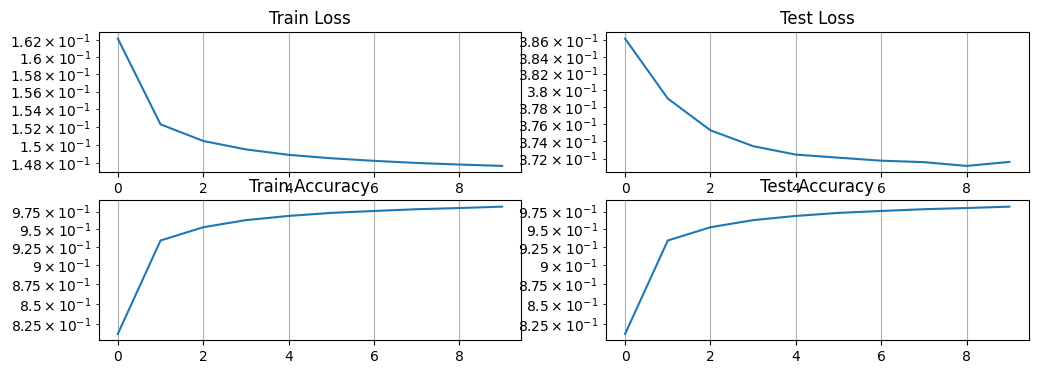

In [12]:
model_1()

**Модель №2**

In [13]:
def model_2(epochs=10):
    print("Test hard model")

    # устройство на котором обучаем, CPU/GPU
    my_device = get_device()

    # создаем модель и переносим на устройство
    model = create_model_conv2d().to(my_device)

    print_count_parameters(model)

    # загрузка и подготовка датасета
    train_loader, test_loader = get_train_and_test_data()

    # запуск обучения

    train_model(model, train_loader, test_loader, device=my_device, epochs=epochs)

Test hard model
use_cuda = True
+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
|  0.weight |    288     |
|   0.bias  |     32     |
|  2.weight |    9216    |
|   2.bias  |     32     |
|  7.weight |   589824   |
|   7.bias  |    128     |
| 10.weight |    1280    |
|  10.bias  |     10     |
+-----------+------------+
Total Trainable Params: 600810
mnist start load ...
mnist loaded ...
start train: epochs = 10, device = cuda
epoch: 1/10, train_loss = 0.161127, train_accuracy = 0.852350, test_loss = 0.373671, test_accuracy = 0.966900
epoch: 2/10, train_loss = 0.151696, train_accuracy = 0.944533, test_loss = 0.372982, test_accuracy = 0.969600
epoch: 3/10, train_loss = 0.150631, train_accuracy = 0.954600, test_loss = 0.371166, test_accuracy = 0.976600
epoch: 4/10, train_loss = 0.150158, train_accuracy = 0.959483, test_loss = 0.370398, test_accuracy = 0.979500
epoch: 5/10, train_loss = 0.150229, train_accuracy = 0.958767, test_loss = 0.370386, test_accur

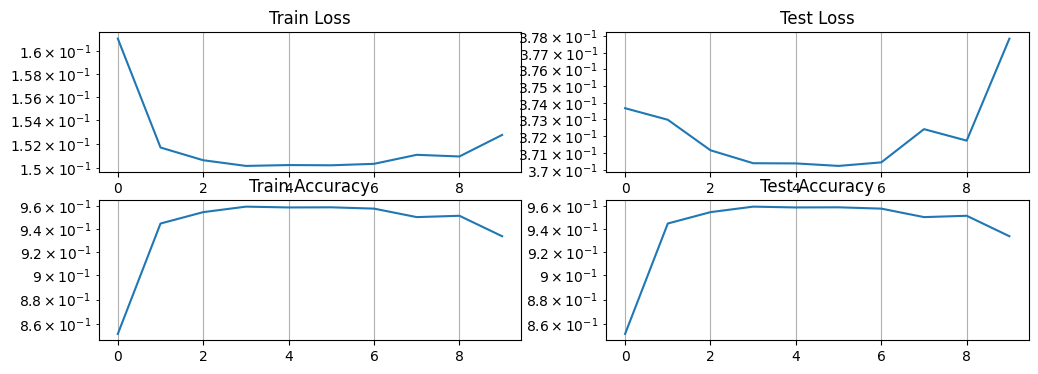

In [14]:
model_2()

### Сравниваем несколько архитектур:

1)

2)

3)

## Выводы:

т